In [17]:
import numpy as np
import os 
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import matplotlib.colors as colors
from scipy import spatial
import SimpleITK as sitk
from sklearn import metrics 
from skimage import morphology, measure
from tqdm import tqdm

In [4]:
segmentation = sitk.ReadImage('C:/Users/korat/Desktop/CRLM_006.nii')
scan = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-006/CRLM-006_CT/1/NIFTI/image.nii')
gt = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-006/CRLM-006_CT/1/NIFTI/segmentation_lesion0_RAD.nii')

segmentation = sitk.GetArrayFromImage(segmentation)
scan = sitk.GetArrayFromImage(scan).astype(np.uint8)
gt = sitk.GetArrayFromImage(gt).astype(np.uint8)

tumor_segment = segmentation
tumor_segment[np.where(segmentation != 2)] = 0
tumor_segment = tumor_segment //2 

tumor_segment = sitk.GetImageFromArray(tumor_segment)
# gt = sitk.GetArrayFromImage(gt)
# scan = sitk.GetArrayFromImage(scan)

print(scan.shape)
print(segmentation.shape)



(75, 512, 512)
(75, 512, 512)


In [24]:
### Ploting stuff

def plot_im_and_overlay(image, mask=None, figsize=(10, 10), dpi = 100, alpha=0.40,
                        color='cyan', colormap='gray', colorbar=False):
    """Plot an image in a matplotlib figure and overlay with a mask."""
    # Define colormap
    validmaps = ['gray', 'turbo', 'jet']


    # Create a normalized colormap for the image and mask
    imin = np.min(image)
    imax = np.max(image)
    norm_im = colors.Normalize(vmin=imin, vmax=imax, clip=False)

    cmap = plt.get_cmap("Blues")
    cmap.set_under(color="white", alpha=0)
    cmap.set_over(color=color, alpha=1)
    normO = colors.Normalize(vmin=0.5, vmax=0.75, clip=False)

    # Plot and save the full image
    fig = plt.figure(figsize=figsize, dpi= dpi)
    ax = fig.add_subplot(1, 1, 1)
    mappable = ax.imshow(image, cmap=colormap, norm=norm_im, interpolation="bilinear")
    if mask is not None:
        ax.imshow(mask, cmap=cmap, norm=normO, alpha=alpha, interpolation="bilinear")

    # Add colorbar
    if colorbar:
        fig.colorbar(mappable)

    # Alter aspect ratio according to figure size
    aspect = figsize[0]/figsize[1]
    ax.set_aspect(aspect)

    # Set locator to zero to make sure padding is removed upon saving
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    # Turn axis grid of
    ax.axis('off')

    return fig

def extract_boundary(contour, radius=2):
    returnitk = False
    if type(contour) is sitk.Image:
        contour = sitk.GetArrayFromImage(contour)
        returnitk = True

    disk = morphology.disk(radius)
    if len(contour.shape) == 3:
        for ind in range(contour.shape[0]):
            contour_d = morphology.binary_dilation(contour[ind, :, :], disk)
            contour_e = morphology.binary_erosion(contour[ind, :, :], disk)
            contour[ind, :, :] = np.bitwise_xor(contour_d, contour_e)
    else:
        contour_d = morphology.binary_dilation(contour, disk)
        contour_e = morphology.binary_erosion(contour, disk)
        contour = np.bitwise_xor(contour_d, contour_e)

    contour = contour.astype(np.uint16)  # To be compatible with SimpleITK
    if returnitk:
        return sitk.GetImageFromArray(contour)
    else:
        return contour

def bbox_2D(img, mask, padding=[1, 1], img2=None):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # print rmin, rmax, cmin, cmax
    rmin = max(0, rmin - padding[0])
    rmax = min(img.shape[0], rmax+padding[0]+1)
    cmin = max(0, cmin - padding[1])
    cmax = min(img.shape[1], cmax+padding[1]+1)

    img = img[rmin:rmax, cmin:cmax]
    mask = mask[rmin:rmax, cmin:cmax]
    if img2 is None:
        return img, mask
    else:
        img2 = img2[rmin:rmax, cmin:cmax]
        return img, mask, img2

def slicer(image, mask=None, output_name=None, output_name_zoom=None,
           thresholds=[-5, 5], zoomfactor=4, dpi=500, normalize=True,
           expand=False, boundary=False, square=False, flip=True, rot90=0,
           alpha=0.40, axis='axial', index=None, color='cyan', radius=2,
           colormap='gray'):
    """Plot slice of image where mask is largest, with mask as overlay.
    image and mask should both be arrays
    """
    # Determine figure size by spacing
    if len(image.GetSize()) == 2:
        # 2D Image
        spacing = [float(image.GetSpacing()[0]), float(image.GetSpacing()[1])]
        imsize = [float(image.GetSize()[0]), float(image.GetSize()[1])]
        figsize = (imsize[0]*spacing[0]/100.0, imsize[1]*spacing[1]/100.0)
    else:
        # 3D Image
        # Determine figure size by spacing
        spacing = [float(image.GetSpacing()[0]), float(image.GetSpacing()[1]), float(image.GetSpacing()[2])]
        imsize = [float(image.GetSize()[0]), float(image.GetSize()[1]), float(image.GetSize()[2])]

        if axis == 'axial':
            figsize = (imsize[0]*spacing[0]/100.0, imsize[1]*spacing[1]/100.0)
        elif axis == 'coronal':
            figsize = (imsize[0]*spacing[0]/100.0, imsize[2]*spacing[2]/100.0)
        elif axis == 'transversal':
            figsize = (imsize[1]*spacing[1]/100.0, imsize[2]*spacing[2]/100.0)

    # Convert images to numpy arrays
    image = sitk.GetArrayFromImage(image)
    if mask is not None:
        mask = sitk.GetArrayFromImage(mask)

    if len(image.shape) == 2:
        # 2D image, so image and mask are already single slices
        imslice = image
        maskslice = mask
    else:
        # Determine which axial slice has the largest area
        if index is None:
            if mask is not None:
                if axis == 'axial':
                    areas = np.sum(mask, axis=2).tolist()
                elif axis == 'coronal':
                    areas = np.sum(mask, axis=1).tolist()
                elif axis == 'transversal':
                    areas = np.sum(mask, axis=0).tolist()

                index = areas.index(max(areas))
            else:
                if axis == 'axial':
                    index = int(image.shape[2]/2)
                elif axis == 'coronal':
                    index = int(image.shape[1]/2)
                elif axis == 'transversal':
                    index = int(image.shape[0]/2)

        if axis == 'axial':
            imslice = image[index, :, :]
        elif axis == 'coronal':
            imslice = image[:, index, :]
        elif axis == 'transversal':
            imslice = image[:, :, index]
        else:
            raise ValueError(f'{axis} is not a valid value for the axis, should be axial, coronal, or transversal.')

        if mask is not None:
            if axis == 'axial':
                maskslice = mask[index, :, :]
            elif axis == 'coronal':
                maskslice = mask[:, index, :]
            elif axis == 'transversal':
                maskslice = mask[:, :, index]
            else:
                raise ValueError(f'{axis} is not a valid value for the axis, should be axial, coronal, or transversal.')
        else:
            maskslice = None

    if rot90 != 0:
        print(f'\t Rotating {rot90 * 90} degrees.')
        imslice = np.rot90(imslice, rot90)
        if mask is not None:
            maskslice = np.rot90(maskslice, rot90)

    if flip:
        print('\t Flipping up-down.')
        imslice = np.flipud(imslice)
        if mask is not None:
            maskslice = np.flipud(maskslice)

    if mask is not None:
        if boundary:
            print('\t Extracting boundary.')
            maskslice = extract_boundary(maskslice, radius)

    if normalize:
        print('\t Normalizing.')
        imslice = sitk.GetImageFromArray(imslice)
        imslice = sitk.Normalize(imslice)
        imslice = sitk.GetArrayFromImage(imslice)

    if square:
        sz = imslice.shape
        if sz[0] != sz[1]:
            print('\t Making image square')
            if sz[0] > sz[1]:
                diff = sz[0] - sz[1]
                newimslice = np.ones((sz[0], sz[0])) * np.min(imslice)
                newimslice[:, int(diff/2.0):sz[1] + int(diff/2.0)] = imslice
                imslice = newimslice

                if mask is not None:
                    newmaskslice = np.zeros((sz[0], sz[0]))
                    newmaskslice[:, int(diff/2.0):sz[1] + int(diff/2.0)] = maskslice
                    maskslice = newmaskslice
            else:
                diff = sz[1] - sz[0]
                newimslice = np.ones((sz[1], sz[1])) * np.min(imslice)
                newimslice[int(diff/2.0):sz[0] + int(diff/2.0), :] = imslice
                imslice = newimslice

                if mask is not None:
                    newmaskslice = np.zeros((sz[1], sz[1]))
                    newmaskslice[int(diff/2.0):sz[0] + int(diff/2.0), :] = maskslice
                    maskslice = newmaskslice

    if expand:
        print('\t Expanding.')
        imslice = sitk.GetImageFromArray(imslice)
        if mask is not None:
            maskslice = sitk.GetImageFromArray(maskslice)

        newsize = (4, 4)
        imslice = sitk.Expand(imslice, newsize)
        if mask is not None:
            maskslice = sitk.Expand(maskslice, newsize)

        # Adjust the size
        if axis == 'axial':
            figsize = (imsize[0]*spacing[0]/100.0, imsize[1]*spacing[1]/100.0)
        elif axis == 'coronal':
            figsize = (imsize[0]*spacing[0]/100.0, imsize[2]*spacing[2]/100.0)
        elif axis == 'transversal':
            figsize = (imsize[1]*spacing[1]/100.0, imsize[2]*spacing[2]/100.0)

        imslice = sitk.GetArrayFromImage(imslice)
        if mask is not None:
            maskslice = sitk.GetArrayFromImage(maskslice)

    # Threshold the image if desired
    if thresholds:
        print("\t Thresholding.")
        imslice[imslice < thresholds[0]] = thresholds[0]
        imslice[imslice > thresholds[1]] = thresholds[1]

    # Plot the image and overlay the mask
    fig = plot_im_and_overlay(imslice, maskslice, figsize=figsize, dpi=dpi, alpha=alpha,
                              color=color, colormap=colormap)

    # Save Output
    if output_name is not None:
        print('\t Saving output.')
        fig.savefig(output_name, bbox_inches='tight', pad_inches=0, dpi=dpi)

    # Save some memory
    # del fig

    if mask is not None:
        if output_name_zoom is not None:
            # Create a bounding box and save zoomed image
            imslice, maskslice = bbox_2D(imslice, maskslice, padding=[20, 20])
            imsize = [float(imslice.shape[0]), float(imslice.shape[1])]

            # NOTE: As these zoomed images get small, we double the spacing
            spacing = spacing * zoomfactor
            figsize = (imsize[0]*spacing[0]/100.0, imsize[1]*spacing[1]/100.0)
            fig = plot_im_and_overlay(imslice, maskslice, figsize=figsize, alpha=alpha)
            fig.savefig(output_name_zoom, bbox_inches='tight', pad_inches=0, dpi=dpi)
            plt.close('all')

            # Save some memory
            del fig, image, mask

    return imslice, maskslice

### Evaluation stuff

def tumor_splitse(segmentation):
    '''
    takes in segmentation of multiple conected components and splits them over images with only one component 
    takes np.array as input
    returns np.array dims=(z,y,x,components)

    '''
    if isinstance(segmentation, sitk.Image):
        segmentation = sitk.GetArrayFromImage(segmentation)
    
    segmentation = measure.label(segmentation)
    # print('max',np.max(segmentation))
    out = np.empty((segmentation.shape[0], segmentation.shape[1], segmentation.shape[2], np.max(segmentation)))

    
    for i in range(1, np.max(segmentation)+1):
        # print('i',i)
        split = np.zeros_like(segmentation, dtype = np.uint8)
        split[np.where(segmentation == i)] = 1
        out[:,:,:,i-1] = split

    return out

def dice_score(img1, img2):
    '''
    calculates dice score for two binary images
    '''
    img1 = np.array(img1)
    img2 = np.array(img2)

    if img1.shape != img2.shape:
        raise ValueError('images must have same shape')
    
    dice = 2 * np.sum(img1 * img2) / (np.sum(img1) + np.sum(img2))
    return dice

def run_dice(segmentation_folder, gt_folder):
    '''
    Runs dice score over all components in segmentation and gt
    returns list of non-zero dice scores
    '''

    dice_scores = []
    for i in tqdm(os.listdir(segmentation_folder)):
        
        if i.endswith('.nii'):
            segmentation = sitk.ReadImage(os.path.join(segmentation_folder, i))
            gt = sitk.ReadImage(gt_folder+i[0:8]+'_0000.nii')
            segmentation = tumor_splitse(segmentation)
            gt = tumor_splitse(gt)

            for j in range(segmentation.shape[3]):
                for k in range(gt.shape[3]):
                    
                    dice = metrics.f1_score(segmentation[:,:,:,j].flatten(), gt[:,:,:,k].flatten())
                    dice_scores.append(dice)
            
    return dice_scores

Batch eval

In [25]:
segmentation_folder = 'C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/Pure_CRLM_data/predictions/'
gt_folder           = 'C:/Users/korat/Desktop/MEP/Data/nnUnet/pure_CRLM/task502_CRLM/labelsTr/'
dice_scores = run_dice(segmentation_folder, gt_folder)

100%|██████████| 34/34 [2:06:50<00:00, 223.84s/it]  


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


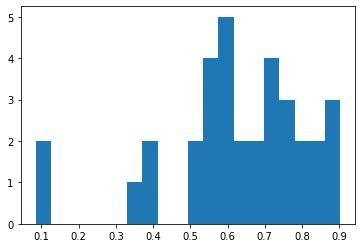

mean dice score:  0.6234968441208588


In [45]:
# print('dice scores: ', (dice_scores))
index = np.array(np.where(np.array(dice_scores) > 0.05)[0])
print((index))
dice_scores = np.array(dice_scores)[index]

plt.hist(dice_scores, bins=20)
plt.show()

print('mean dice score: ', np.mean(dice_scores))

AttributeError: module 'matplotlib.pyplot' has no attribute 'tick_labels'

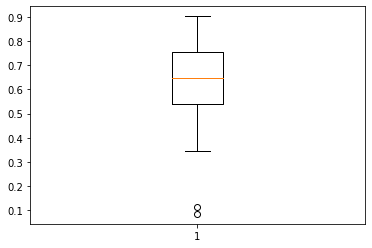

In [47]:
plt.boxplot(dice_scores)

plt.show()

Tests

In [ ]:
scan = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-006/CRLM-006_CT/1/NIFTI/image.nii')
gt = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/nnUnet/task501_CRLM/labelTr/CRLM_002.nii')
segmentation = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/nnUnet/segment_results/CRLM_seg_nnUNet/CRLM_002.nii')

gt_splitsed = tumor_splitse(gt)
segmented_splitsed = tumor_splitse(segmentation)

gt_splitsed.shape , segmented_splitsed.shape

In [ ]:
segmentation = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/nnUnet/segment_results/CRLM_seg_nnUNet/CRLM_002.nii')
segmentation  = sitk.GetArrayFromImage(segmentation)
print(segmentation.shape)

plt.imshow(segmentation[67,:,:])
plt.show()

for i in os.listdir('C:/Users/korat/Desktop/MEP/Data/nnUnet/segment_results/CRLM_seg_nnUNet/'):
    segmentation = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/nnUnet/segment_results/CRLM_seg_nnUNet/' + i)
    segmentation  = sitk.GetArrayFromImage(segmentation)
    print(segmentation.shape)

    plt.imshow(segmentation[67,:,:])
    plt.show()

In [ ]:
for i in range(gt_splitsed.shape[3]):
    for j in range(segmented_splitsed.shape[3]):
        dice = dice_score(gt_splitsed[:,:,:,i].flatten(), segmented_splitsed[:,:,:,j].flatten())
        print(dice)

NameError: name 'gt_splitsed' is not defined

max 3
i 1
i 2
i 3
(75, 512, 512, 3)
	 Making image square
	 Expanding.
	 Thresholding.
	 Extracting boundary.
	 Making image square
	 Expanding.
	 Thresholding.
	 Extracting boundary.
	 Making image square
	 Expanding.
	 Thresholding.
	 Extracting boundary.
	 Making image square
	 Expanding.
	 Thresholding.
rad dice: 0.531563126252505
student dice: 0.6580728327425073


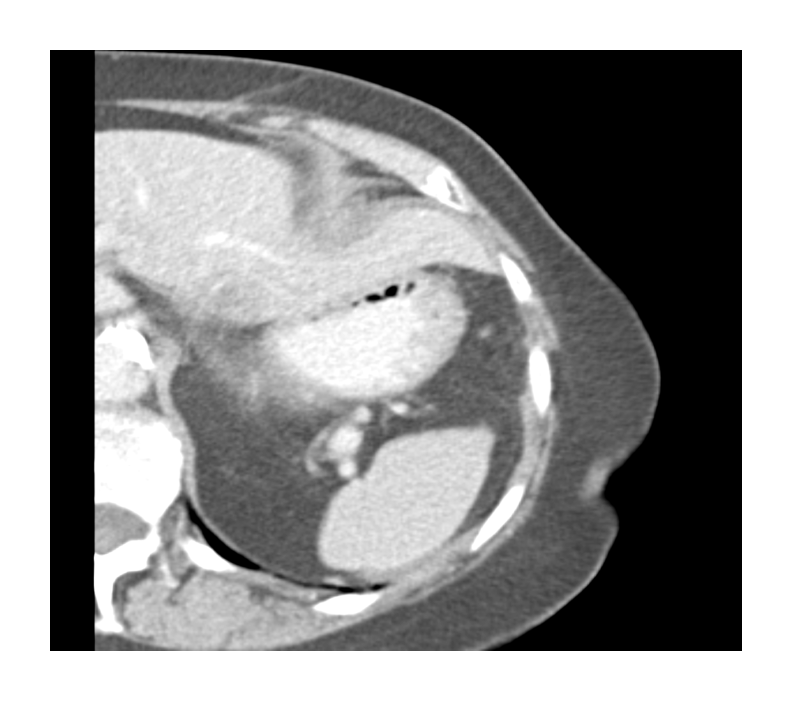

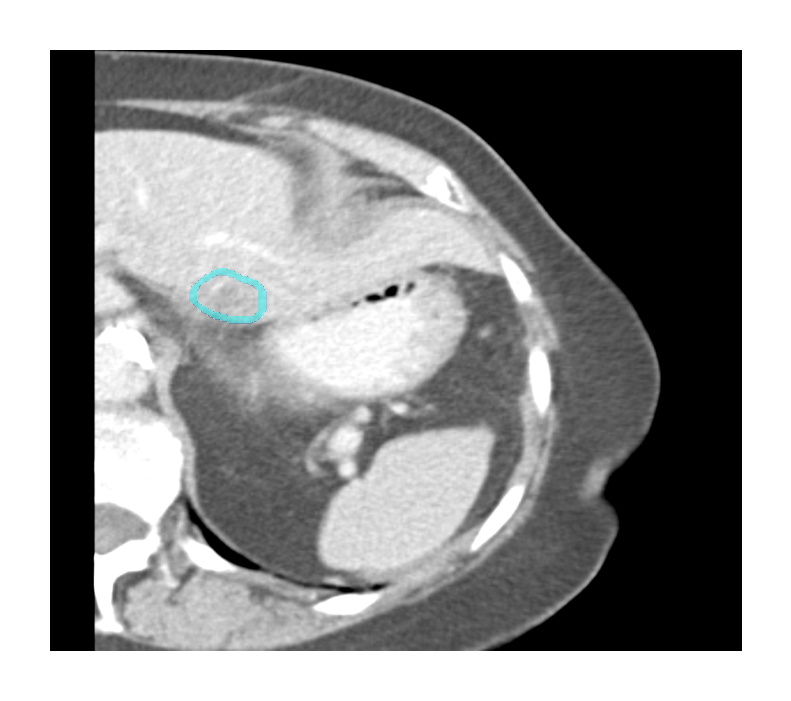

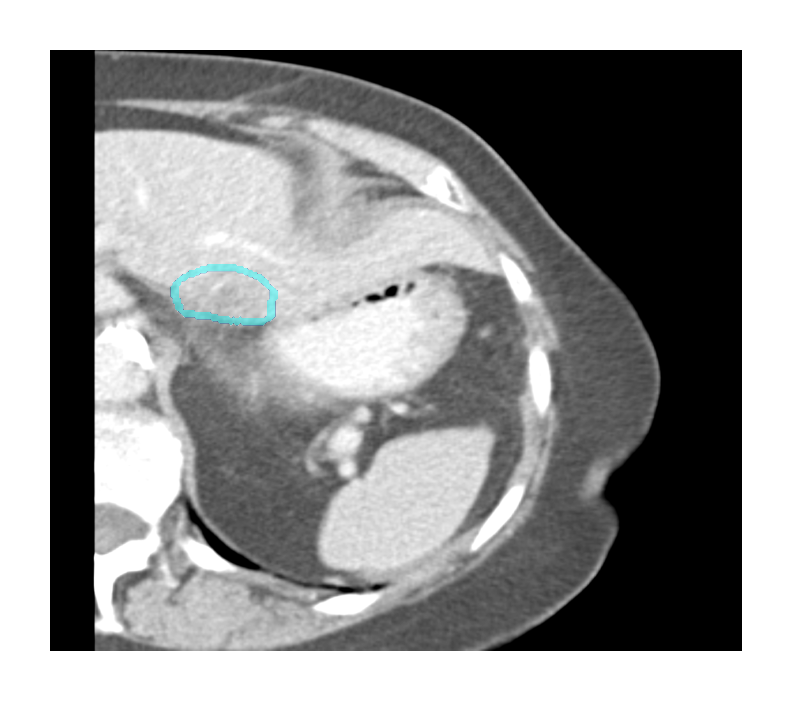

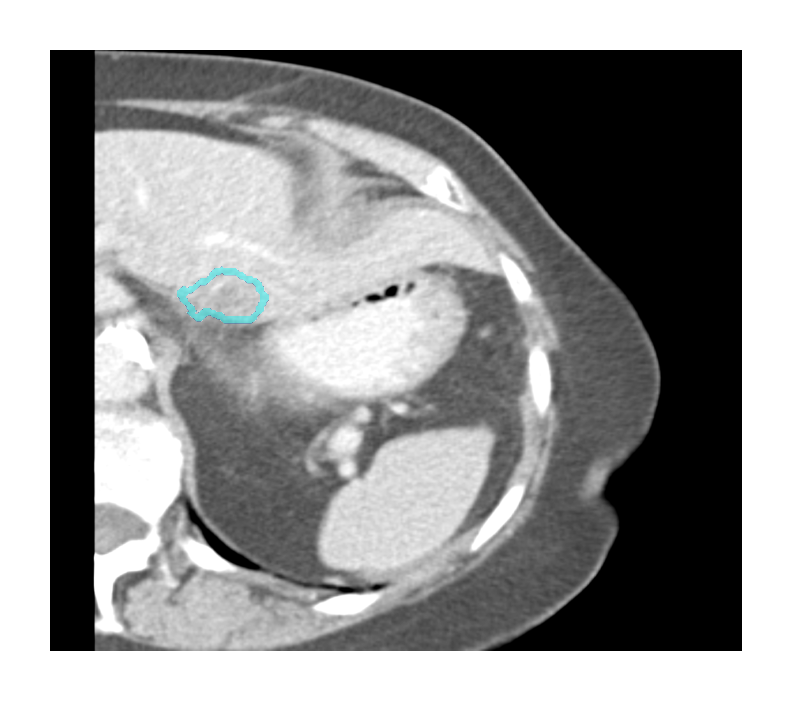

In [ ]:
scan = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-006/CRLM-006_CT/1/NIFTI/image.nii')
gt = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-006/CRLM-006_CT/1/NIFTI/segmentation_lesion0_RAD.nii')
gt_student = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-006/CRLM-006_CT/1/NIFTI/segmentation_lesion0_STUD1.nii')
segmentation_folder = 'C:/Users/korat/Desktop/CRLM_006.nii'

segmentation = sitk.ReadImage(segmentation_folder)
segmentation  = sitk.GetArrayFromImage(segmentation)

tumor_splitsed = (tumor_splitse(segmentation))


print(tumor_splitsed.shape)
tumor_segment = sitk.GetImageFromArray(tumor_splitsed[:,:,:,1])
extend =  slice(250,511),slice(100,400), 67

slicer(scan[extend], mask = None,  output_name_zoom=None,
           thresholds=[-240, 160], zoomfactor=4, dpi=500, normalize=False,
           expand=True, boundary=True, square=True, flip=False, rot90=0,
           alpha=0.40, axis='axial', index=None, color='red', radius=2,
           colormap='gray')
slicer(scan[extend], mask = tumor_segment[extend],  output_name_zoom=None,
           thresholds=[-240, 160], zoomfactor=4, dpi=500, normalize=False,
           expand=True, boundary=True, square=True, flip=False, rot90=0,
           alpha=0.40, axis='axial', index=None, color='red', radius=2,
           colormap='gray')
slicer(scan[extend], mask = gt[extend],output_name_zoom=None,
           thresholds=[-240, 160], zoomfactor=4, dpi=500, normalize=False,
           expand=True, boundary=True, square=True, flip=False, rot90=0,
           alpha=0.40, axis='axial', index=None, color='cyan', radius=2,
           colormap='gray')

slicer(scan[extend], mask = gt_student[extend],output_name_zoom=None,
           thresholds=[-240, 160], zoomfactor=4, dpi=500, normalize=False,
           expand=True, boundary=True, square=True, flip=False, rot90=0,
           alpha=0.40, axis='axial', index=None, color='cyan', radius=2,
           colormap='gray')

tumor_segment = sitk.GetArrayFromImage(tumor_segment)
gt = sitk.GetArrayFromImage(gt)
st_student = sitk.GetArrayFromImage(gt_student)

print('rad dice:' ,dice_score(gt.flatten(), tumor_segment.flatten()))
print('student dice:' ,dice_score(st_student.flatten(), tumor_segment.flatten()))

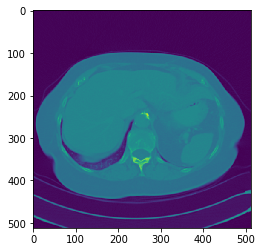

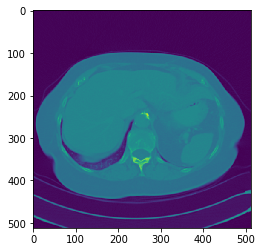

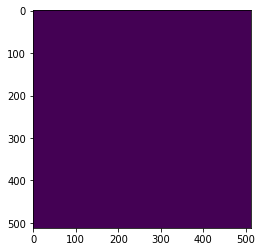

In [ ]:
scan1 = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-002/CRLM-002_CT/1/NIFTI/image.nii')
scan2 = sitk.ReadImage('C:/Users/korat/Desktop/MEP/Data/WORC_CRLM/CRLM-010/CRLM-010_CT/1/NIFTI/image.nii')

scan1 = sitk.GetArrayFromImage(scan1)
scan2 = sitk.GetArrayFromImage(scan2)

plt.imshow(scan1[67,:,:])
plt.show()
plt.imshow(scan2[67,:,:])
plt.show()
plt.imshow(scan2[67,:,:]-scan1[67,:,:])
plt.show()